# Week 2: Classic Convolutional Neural Network Architectures

## Introduction

- In Week 2 of the `Convolutional Neural Networks` course, Andrew Ng explores the evolution of CNN architectures that have revolutionized computer vision.

- This tutorial covers these landmark architectures, their innovations, and implementation details.

- [Reference Video Link](https://www.youtube.com/watch?v=-bvTzZCEOdM&ab_channel=DeepLearningAI)


## Why Study Classic Architectures?

Understanding classic `CNN` architectures provides several benefits:

- Learn valuable architectural principles and design patterns

- Gain insights into the evolution of deep learning for computer vision

- Apply these proven architectures to your own problems via transfer learning

- Build intuition for designing custom architecture


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import vgg16, alexnet, resnet50, inception_v3, mobilenet_v2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## LeNet-5

- `LeNet-5 `was developed by `Yann LeCun` in 1998 and was one of the earliest CNNs used successfully for digit recognition (`MNIST`).

### Architecture

- **Input**: $32×32×1$ grayscale images

- **Layer 1**: $6$ filters of size $5×5$, stride $1$ → $28×28×6$

  - Followed by average pooling with $2×2$ filter, stride $2$ → $14×14×6$

- Layer 2: $16$ filters of size $5×5$, stride $1$ → $10×10×16$

  - Followed by average pooling with $2×2$ filter, stride $2$ → $5×5×16$

- Flatten: $5×5×16 = 400$ units

- Fully Connected: $400 → 120$ units

- Fully Connected: $120 → 84$ units

- Output Layer: $84 → 10$ units

  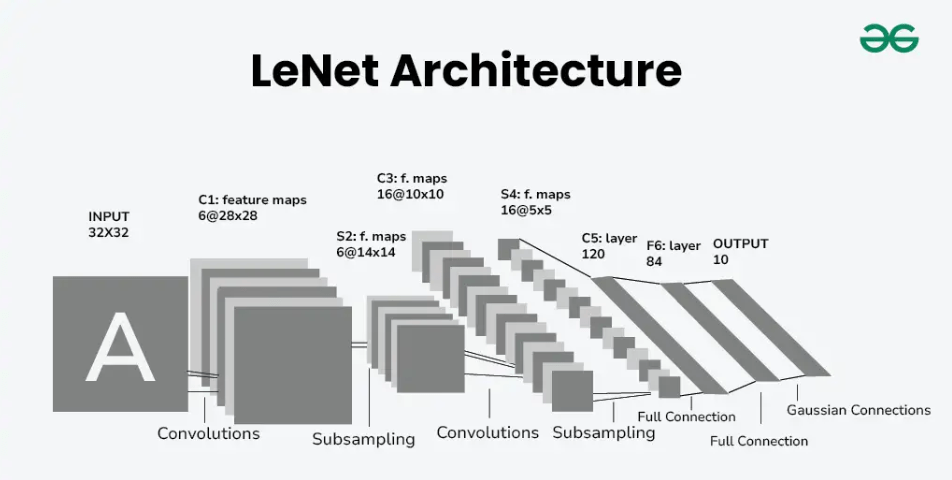


### Key Innovations

- Convolutional layers to extract spatial features

- `Average pooling` for dimensionality reduction

- `Tanh` activation functions (`ReLU` wasn't popular yet)

  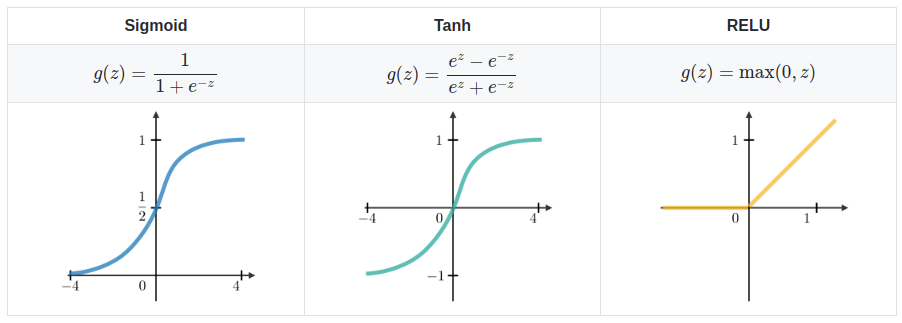

### Limitations

- Shallow network (few layers)

- Limited by computing power of the time

- Used `average pooling` instead of `max pooling`


### Code Example


Training LeNet-5 model...
Train Batch: 0/938 Loss: 2.308252


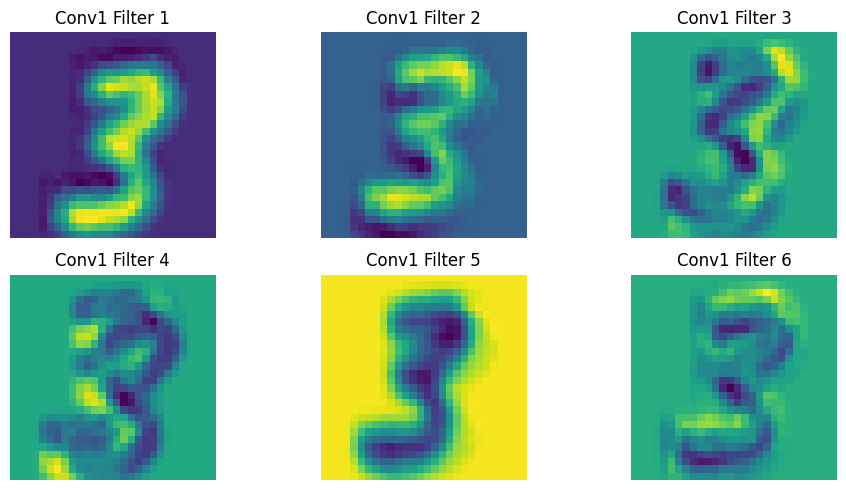

Train Batch: 100/938 Loss: 0.676136


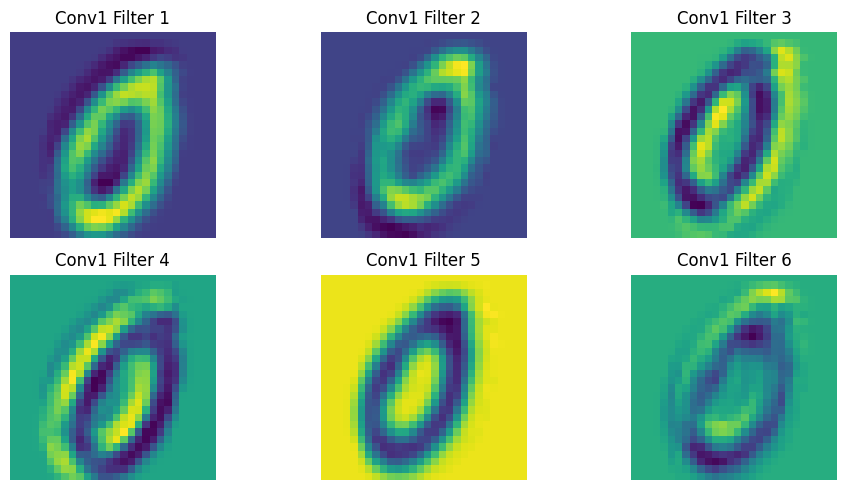

Train Batch: 200/938 Loss: 0.334878


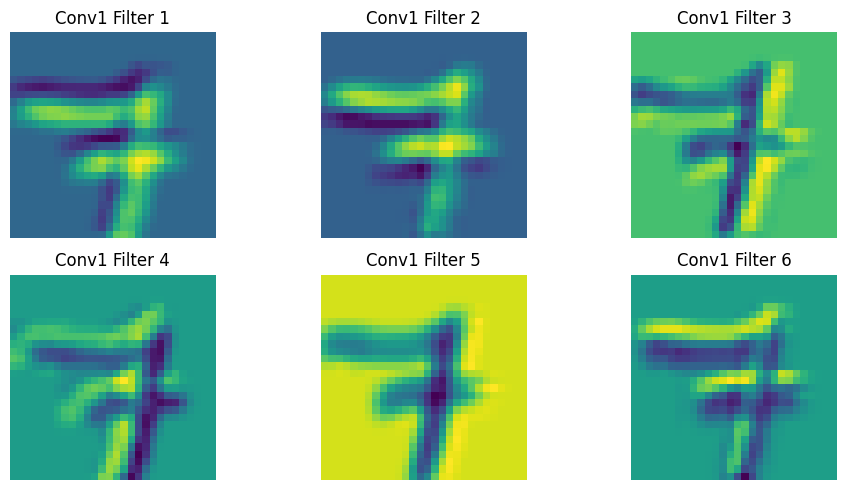

In [2]:
#==========================================================================
# 1. LeNet-5 Architecture
#==========================================================================
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # First convolutional layer: 1x32x32 -> 6x28x28
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        # Average pooling: 6x28x28 -> 6x14x14
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        # Second convolutional layer: 6x14x14 -> 16x10x10
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        # Average pooling: 16x10x10 -> 16x5x5
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # First block: Conv + AvgPool + Tanh
        x = self.conv1(x)
        x = self.avg_pool1(x)
        x = torch.tanh(x)
        
        # Second block: Conv + AvgPool + Tanh
        x = self.conv2(x)
        x = self.avg_pool2(x)
        x = torch.tanh(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 16 * 5 * 5)
        
        # Fully connected layers with Tanh activations
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
def train_lenet():
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # LeNet-5 expects 32x32 images
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, 
                                              download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                             shuffle=True)
    
    # Initialize model, loss function, and optimizer
    model = LeNet5().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    # Train for 1 epoch
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Batch: {batch_idx}/{len(train_loader)} ' 
                  f'Loss: {loss.item():.6f}')
            
            # Visualize feature maps for the first image in batch
            with torch.no_grad():
                # Extract feature maps after first conv layer
                conv1_output = model.conv1(data[0:1])
                
                # Plot the first 6 feature maps
                plt.figure(figsize=(10, 5))
                for i in range(6):
                    plt.subplot(2, 3, i+1)
                    plt.imshow(conv1_output[0, i].cpu().numpy(), cmap='viridis')
                    plt.title(f'Conv1 Filter {i+1}')
                    plt.axis('off')
                plt.tight_layout()
                plt.show()
                # plt.savefig(f'lenet_feature_maps_{batch_idx}.png')
                plt.close()
                
            # We only want to process a few batches for this demo
            if batch_idx >= 200:
                break
    
    return model

# Train LeNet-5 model
print('Training LeNet-5 model...')
model = train_lenet()

## AlexNet

- `AlexNet`, developed by `Alex Krizhevsky`, `Ilya Sutskever`, and` Geoffrey Hinton`, won the ImageNet competition in 2012 with a top-5 error of 15.3% (compared to 26.2% for the second-best entry).

### Architecture

- **Input**: $227×227×3$ RGB images

- **Layer 1**: $96$ filters of size $11×11$, stride $4$ → $55×55×96$

  - Followed by` max pooling` with $3×3$ filter, stride $2$ → $27×27×96$

  - Local Response Normalization (`LRN`)

- **Layer 2**: $256$ filters of size $5×5$, stride $1$, `same padding` → $27×27×256$

  - Followed by `max pooling` with $3×3$ filter, stride 2 → $13×13×256$

  - `LRN`

- **Layer 3**: $384$ filters of size $3×3$, stride $1$, `same padding` → $13×13×384$

- **Layer 4**: $384$ filters of size $3×3$, stride $1$, `same padding` → $13×13×384$

- **Layer 5**: $256$ filters of size $3×3$, stride $1$, `same padding` → $13×13×256$

  - Followed by `max pooling` with $3×3$ filter, stride $2$ → $6×6×256$

- **Flatten**: $6×6×256 = 9216$ units

- **Fully Connected:** $9216 → 4096$ units

- **Fully Connected**: $4096 → 4096$ units

- **Output Layer**: $4096 → 1000$ units (ImageNet classes)

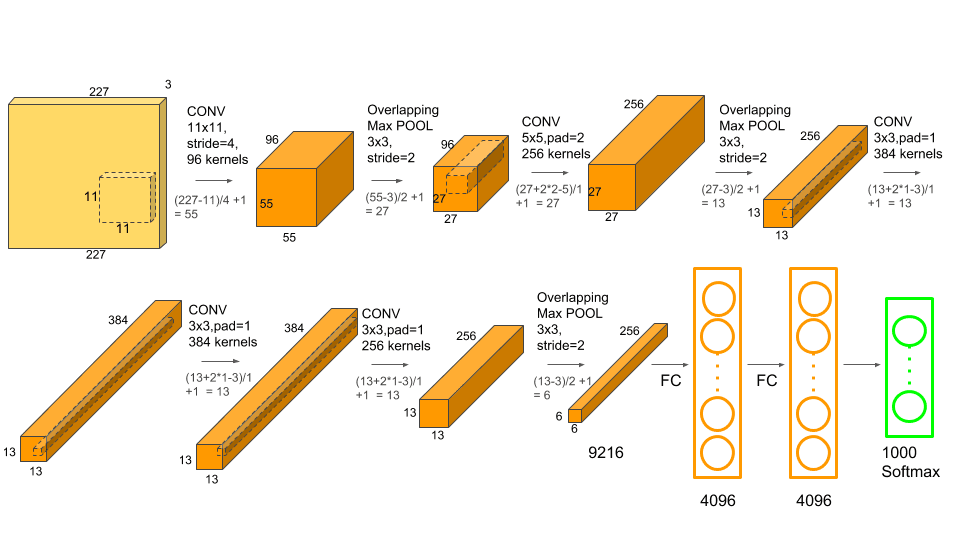


### Key Innovations

- Much deeper than LeNet (8 layers vs. 5)

- Used `ReLU` activations which helped address the vanishing gradient problem

- Implemented `dropout` ($0.5$) to reduce `overfitting`

- Data augmentation (`flipping`, `cropping`,` color jittering`)

- Local Response Normalization

  - No longer useful for now

- Trained on GPUs (2 NVIDIA GTX 580)


### Code Example


Visualizing AlexNet filters...


c:\Users\yy00021\.conda\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


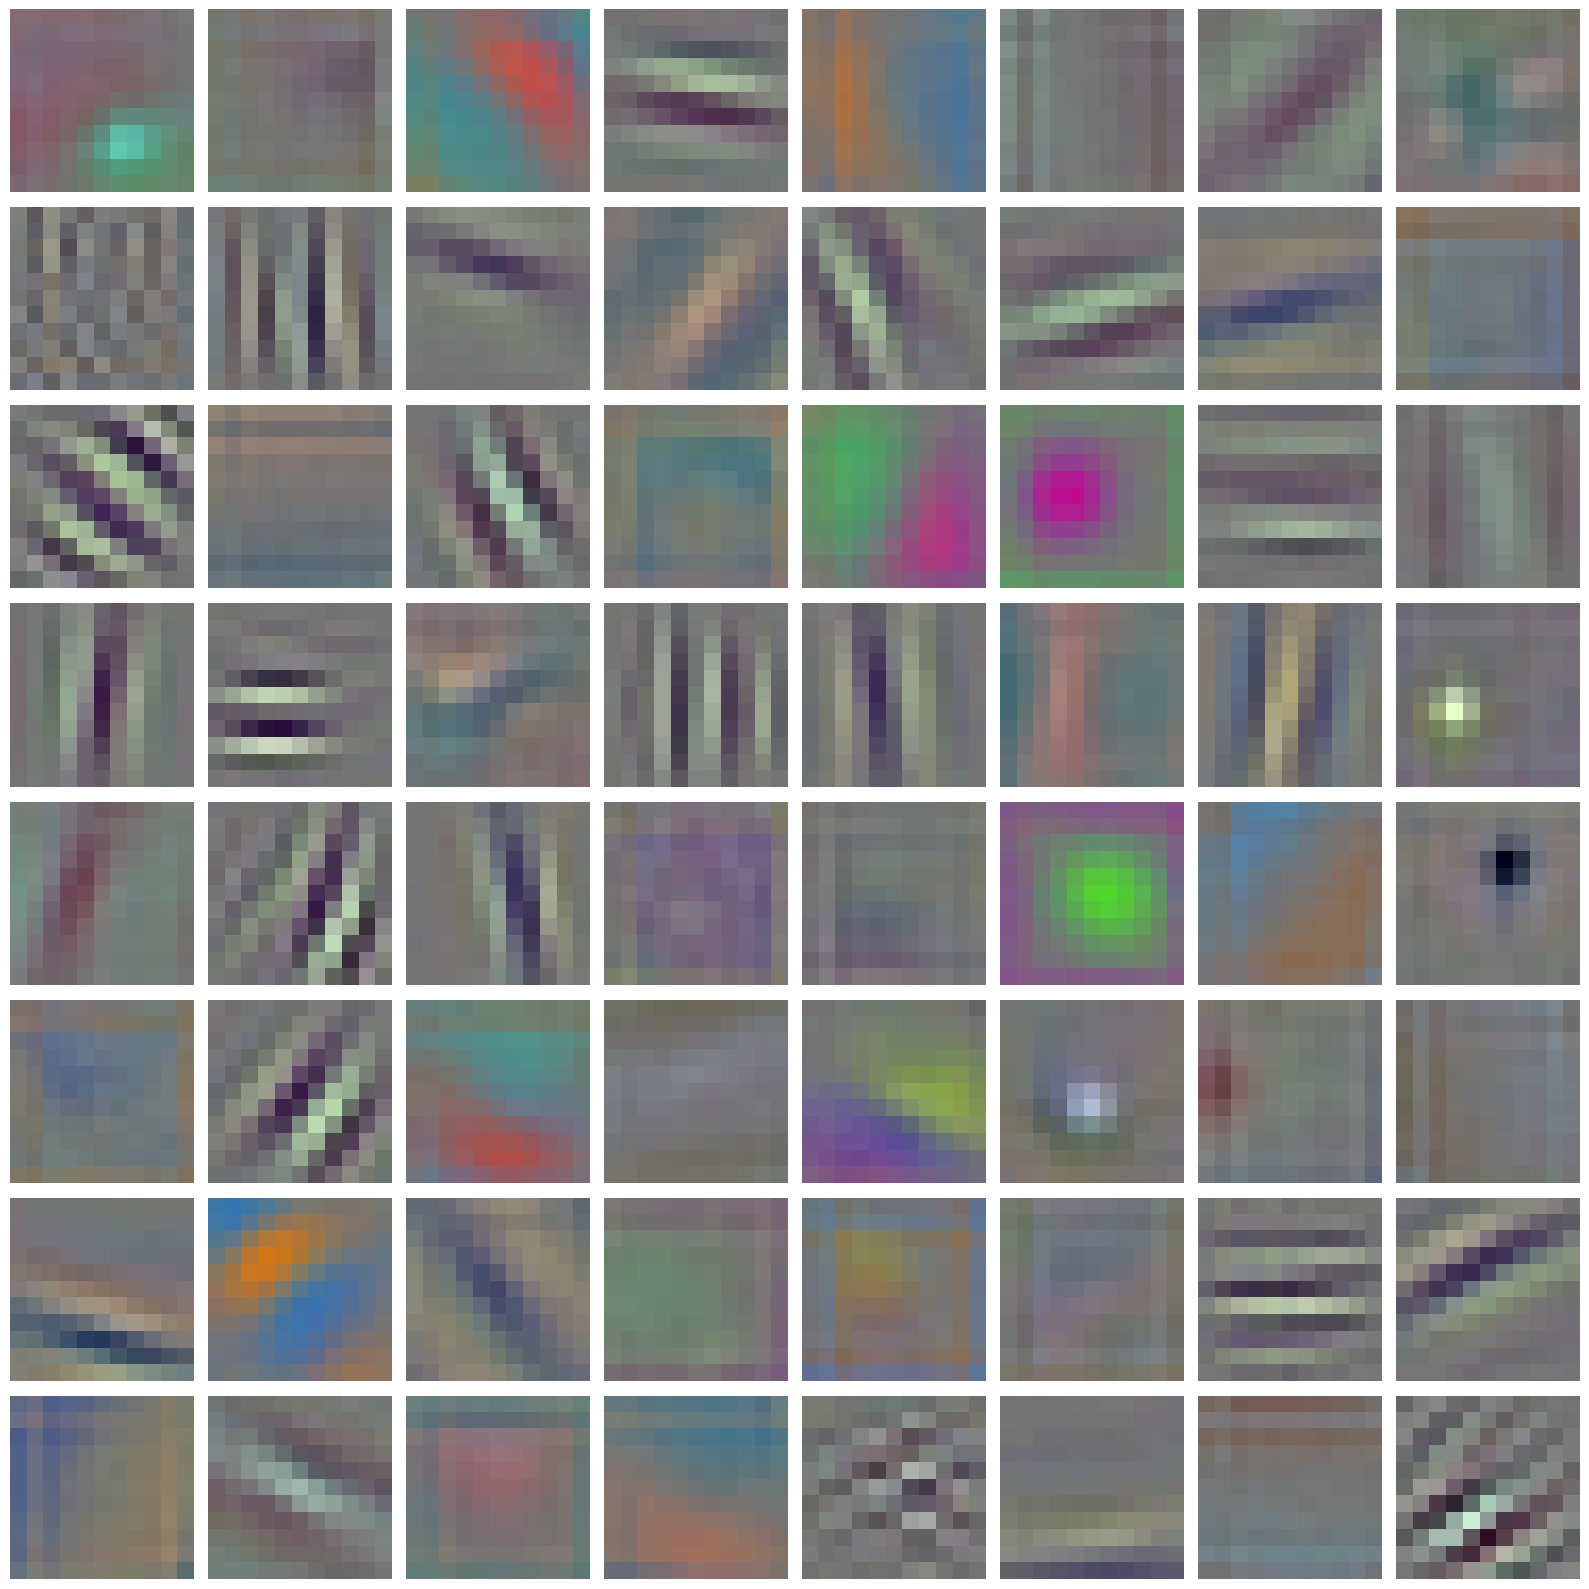

In [3]:
#==========================================================================
# 2. AlexNet Architecture
#==========================================================================
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # First convolutional block: Conv + ReLU + MaxPool + LRN
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            
            # Layer 2
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            
            # Layer 3
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Layer 4
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Layer 5
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def visualize_alexnet_filters():
    # Load a pre-trained AlexNet
    model = torchvision.models.alexnet(weights=True)
    
    # Get the first convolutional layer's filters
    filters = model.features[0].weight.data.clone()
    
    # Normalize the filters for better visualization
    filters = (filters - filters.min()) / (filters.max() - filters.min())
    
    # Plot the first 64 filters
    plt.figure(figsize=(16, 16))
    for i in range(64):
        plt.subplot(8, 8, i+1)
        # For RGB images, transpose to (H, W, C)
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(filter_img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    # plt.savefig('alexnet_filters.png')
    plt.close()
    
    return model

# Visualize AlexNet filters
print('Visualizing AlexNet filters...')
model = visualize_alexnet_filters()

## VGG-16

- `VGG-16` was developed by the Visual Geometry Group at Oxford in 2014 and was notable for its simplicity and depth.

### Architecture

- **Input**: $224×224×3$ RGB images

- Convolutional Blocks:

  - **Block 1**: **Two** $3×3$ conv layers with $64$ filters with `same padding` + `max pooling`

  - **Block 2**: **Two** $3×3$ conv layers with $128$ filters with `same padding` + `max pooling`

  - **Block 3**: **Three** $3×3$ conv layers with $256$ filters with `same padding` + `max pooling`

  - **Block 4**: **Three** $3×3$ conv layers with $512$ filters with `same padding` + `max pooling`

  - **Block 5**: **Three** $3×3$ conv layers with $512$ filters with `same padding` + `max pooling`

- **Flatten**: $7×7×512 = 25,088$ units

- **Fully Connected**: $25,088 → 4096$ units

- **Fully Connected**: $4096 → 4096$ units

- **Output Layer**: $4096 → 1000$ units (ImageNet classes)

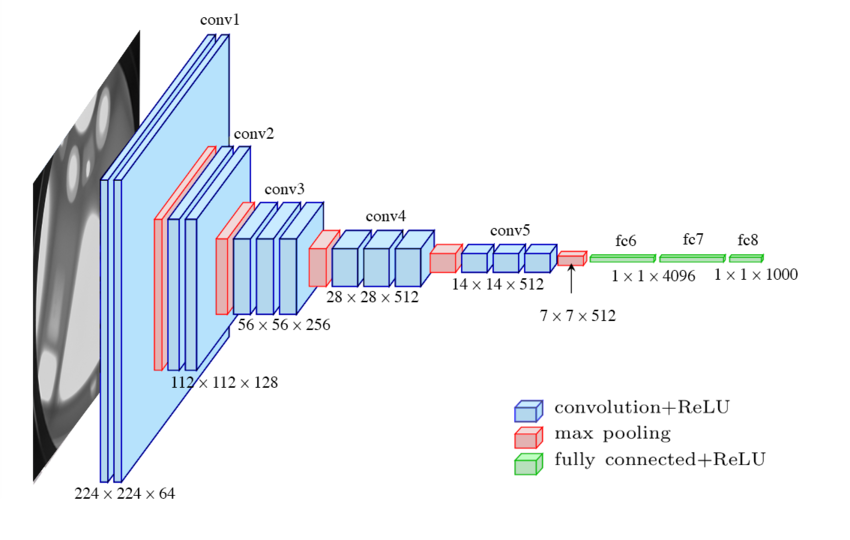

### Key Innovation

- Used small $3×3$ filters exclusively throughout the network

- Showed that **multiple stacked $3×3$ convolutions** can effectively create larger receptive fields (e.g., two stacked $3×3$ filters have a $5×5$ effective receptive field) with fewer parameters

- Very uniform architecture with a pattern of `convolutional layers` followed by `max pooling`

- Demonstrated that **`depth` is critical for performance**

### Limitations

- Very large number of parameters (138 million)

- Computationally expensive to train and deploy

Comparing VGG architectures...
VGG16 parameters: 138,357,544
VGG Small parameters: 7,883,144


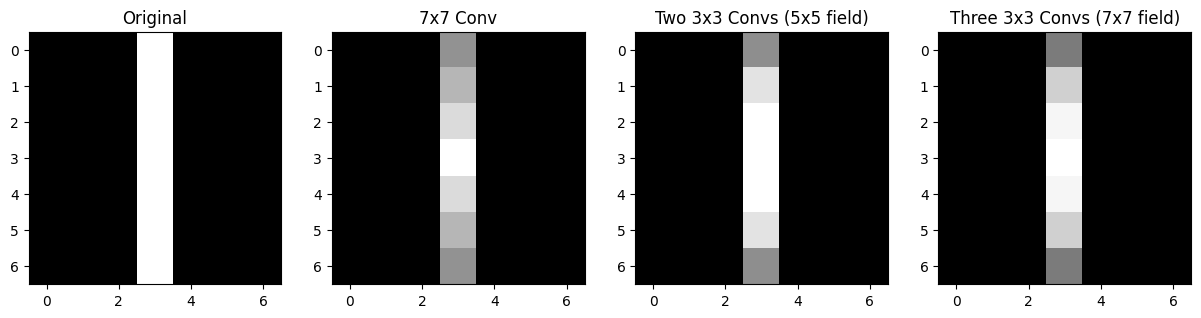

In [5]:
#==========================================================================
# 3. VGG-16 Architecture
#==========================================================================
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        # Block 1: 2 conv layers with 64 filters
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 2: 2 conv layers with 128 filters
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 3: 3 conv layers with 256 filters
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 4: 3 conv layers with 512 filters
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 5: 3 conv layers with 512 filters
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
        
        # Initialize weights
        self._initialize_weights()
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def compare_vgg_architectures():
    # Compare the parameters of different VGG models
    vgg16_model = vgg16(weights=False)
    
    # Create a smaller version with fewer filters (for demonstration)
    class VGGSmall(nn.Module):
        def __init__(self, num_classes=1000):
            super(VGGSmall, self).__init__()
            # Similar structure but with half the filters
            self.features = nn.Sequential(
                # Block 1
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                # Block 2
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                # Block 3
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
            self.classifier = nn.Sequential(
                nn.Linear(128 * 7 * 7, 1024),
                nn.ReLU(True),
                nn.Linear(1024, num_classes),
            )
    
    vgg_small = VGGSmall()
    
    # Count parameters
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters())
    
    print(f"VGG16 parameters: {count_parameters(vgg16_model):,}")
    print(f"VGG Small parameters: {count_parameters(vgg_small):,}")
    
    # Show the effectiveness of stacking 3x3 filters
    # Demonstrate receptive field calculation
    
    # Two stacked 3x3 convs have a 5x5 effective receptive field
    # Three stacked 3x3 convs have a 7x7 effective receptive field
    
    # Create a sample 7x7 image with a vertical line
    image = torch.zeros(1, 1, 7, 7)
    image[0, 0, :, 3] = 1  # Vertical line in the middle
    
    # Define different convolutions
    conv_7x7 = nn.Conv2d(1, 1, kernel_size=7, padding=3, bias=False)
    conv_3x3_1 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
    conv_3x3_2 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
    conv_3x3_3 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
    
    # Initialize weights to detect vertical lines
    with torch.no_grad():
        # 7x7 filter: vertical line detector
        conv_7x7.weight.fill_(0)
        conv_7x7.weight[0, 0, :, 3] = 1/7
        
        # First 3x3 filter 
        conv_3x3_1.weight.fill_(0)
        conv_3x3_1.weight[0, 0, :, 1] = 1/3
        
        # Second 3x3 filter
        conv_3x3_2.weight.fill_(0)
        conv_3x3_2.weight[0, 0, :, 1] = 1/3
        
        # Third 3x3 filter
        conv_3x3_3.weight.fill_(0)
        conv_3x3_3.weight[0, 0, :, 1] = 1/3
    
    # Apply convolutions
    output_7x7 = conv_7x7(image)
    
    output_3x3_1 = conv_3x3_1(image)
    output_3x3_2 = conv_3x3_2(output_3x3_1)
    output_3x3_3 = conv_3x3_3(output_3x3_2)
    
    # Display results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image[0, 0].numpy(), cmap='gray')
    plt.title('Original')
    plt.subplot(1, 4, 2)
    plt.imshow(output_7x7[0, 0].detach().numpy(), cmap='gray')
    plt.title('7x7 Conv')
    plt.subplot(1, 4, 3)
    plt.imshow(output_3x3_2[0, 0].detach().numpy(), cmap='gray')
    plt.title('Two 3x3 Convs (5x5 field)')
    plt.subplot(1, 4, 4)
    plt.imshow(output_3x3_3[0, 0].detach().numpy(), cmap='gray')
    plt.title('Three 3x3 Convs (7x7 field)')
    # plt.savefig('vgg_receptive_field.png')
    plt.show()
    plt.close()
    
# Compare VGG architectures
print('Comparing VGG architectures...')
compare_vgg_architectures()

## ResNet

- `ResNet` (Residual Network), introduced by Microsoft Research in 2015, won the ImageNet competition with a revolutionary architecture that allowed for training much deeper networks.

### Architecture

- Based on the "`residual block`" concept

    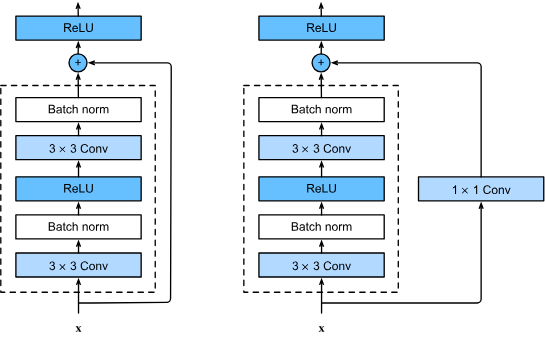

- Variants include `ResNet-18`, `ResNet-34`, `ResNet-50`, `ResNet-101`, and `ResNet-152`

- For `ResNet-50`:

  - **Input**: $224×224×3$ RGB images
  - **Initial**: $7×7$ conv with $64$ filters, stride $2$ + `max pooling`
  - **Stage 1**: $3$ residual blocks, each with $[1×1, 64], [3×3, 64], [1×1, 256]$ convolutions
  - **Stage 2**: $4$ residual blocks, each with $[$1×1, 128], [3×3, 128], [1×1, 512]$ convolutions
  - **Stage 3**: $6$ residual blocks, each with $[1×1, 256], [3×3, 256], [1×1, 1024]$ convolutions
  - **Stage 4**: $3$ residual blocks, each with $[1×1, 512], [3×3, 512], [1×1, 2048]$ convolutions
  - **Global Average Pooling**: Produces a $2048$-dimensional vector
  - **Output Layer**: $2048 → 1000$ units (ImageNet classes)


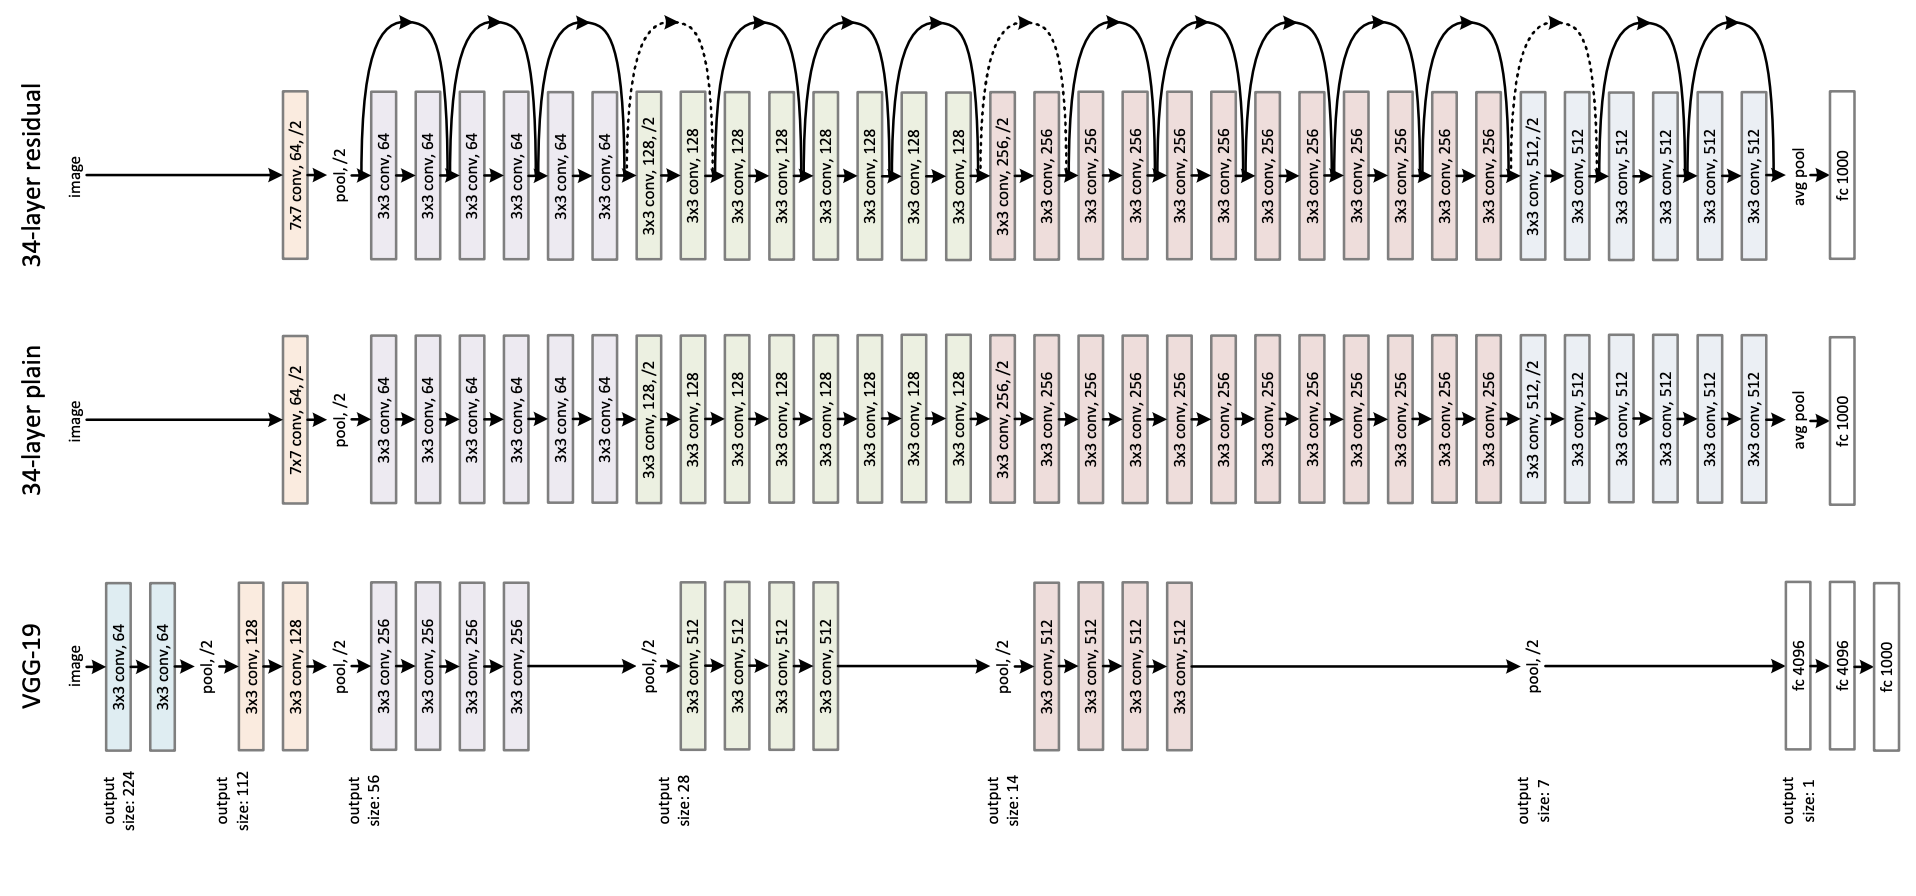


### Key Innovation: Residual Blocks

ResNet's key innovation is the `residual block` with a "`skip connection`" that allows gradients to flow through the network more easily:

```bash
    Input
      |
      v
 Convolutions
      |
      v
   ReLU
      |
      v
 Convolutions
      |
      v
   Add <---- Skip Connection from Input
      |
      v
   ReLU
      |
      v
    Output
```
- This architecture addresses the degradation problem, where adding more layers to a deep network can lead to higher training error. 

- The skip connections allow the network to learn the identity function, ensuring that deeper networks perform at least as well as shallower ones.

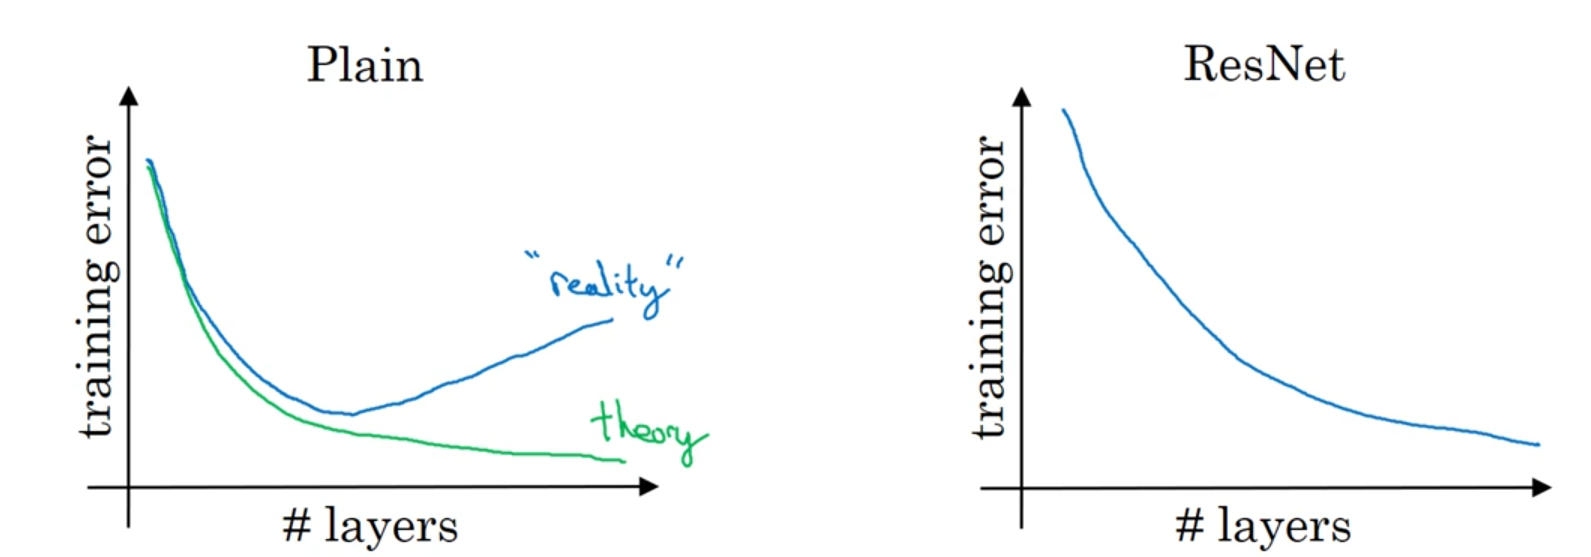

### Benefits

- Enabled training of **much deeper networks** (up to $152$ layers)

- **Reduced parameters** compared to VGG (`ResNet-34` has $3.6$ million parameters vs. `VGG-16`'s $138$ million)

- Better performance on image classification tasks

- Easier optimization and training convergence

### Code Example

Demonstrating residual learning...


<Figure size 1000x800 with 0 Axes>

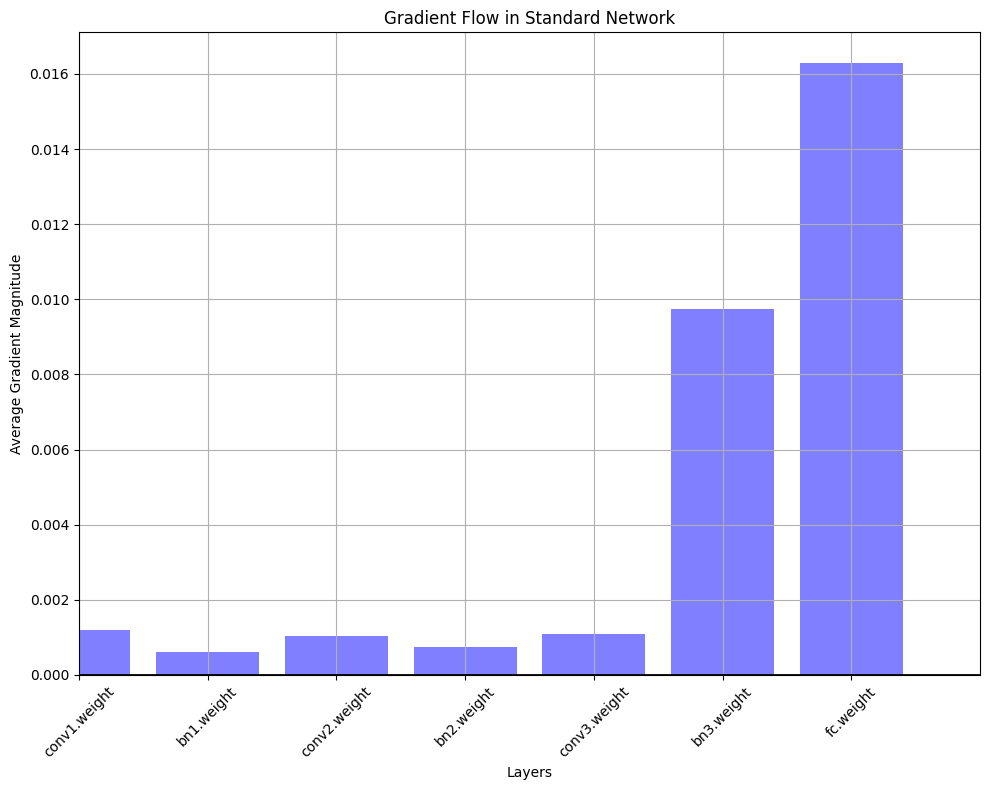

<Figure size 1000x800 with 0 Axes>

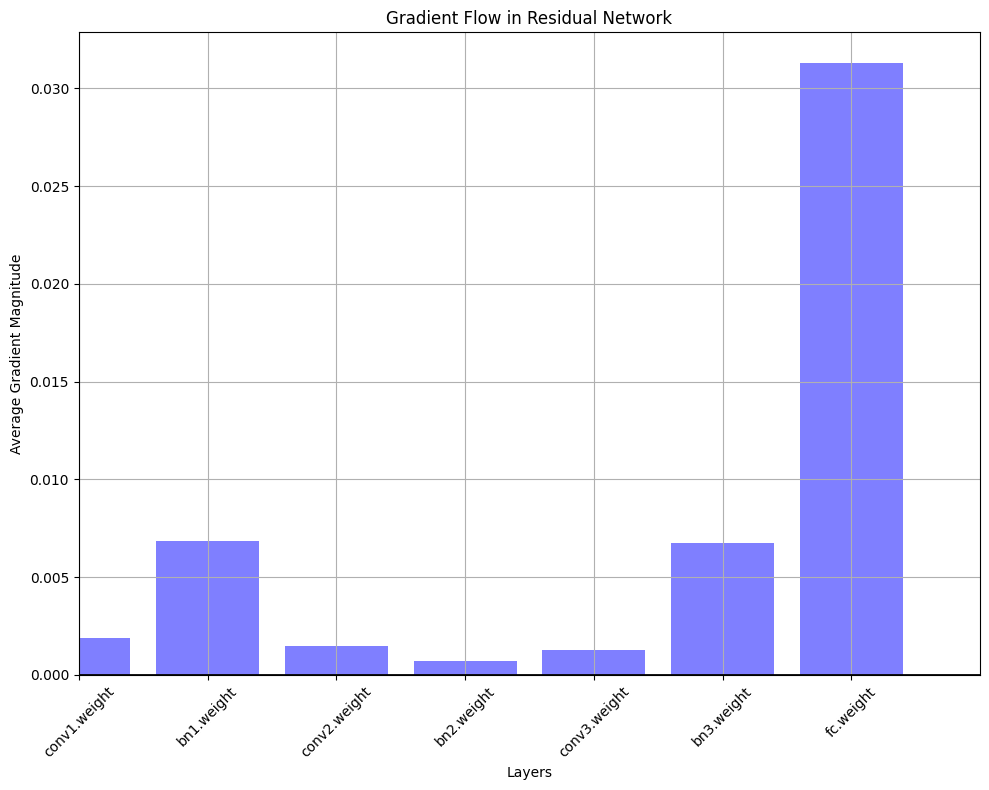

In [9]:
#==========================================================================
# 4. ResNet Architecture
#==========================================================================
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection (shortcut)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Add skip connection
        out += self.shortcut(identity)
        out = F.relu(out)
        
        return out

class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        # 1x1 convolution for dimensionality reduction
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3x3 convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 1x1 convolution for dimensionality increase
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        
        # Add skip connection
        out += self.shortcut(identity)
        out = F.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        # Initial convolution and pooling
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # Global average pooling and final FC layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        
        # First block with potential downsampling
        layers.append(block(self.in_channels, out_channels, stride))
        
        # Update in_channels for subsequent blocks
        self.in_channels = out_channels * block.expansion
        
        # Remaining blocks
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def demonstrate_residual_learning():
    # Create a simple network to demonstrate the impact of residual connections
    class SimpleNetwork(nn.Module):
        def __init__(self, use_residual=False):
            super(SimpleNetwork, self).__init__()
            self.use_residual = use_residual
            
            # Simple stack of layers
            self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(16)
            self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(16)
            self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(16)
            
            # Final classification layer
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(16, 10)
        
        def forward(self, x):
            out = F.relu(self.bn1(self.conv1(x)))
            
            # Store the identity for potential residual connection
            identity = out
            
            out = F.relu(self.bn2(self.conv2(out)))
            out = self.bn3(self.conv3(out))
            
            # Add residual connection if specified
            if self.use_residual:
                out += identity
                
            out = F.relu(out)
            out = self.avgpool(out)
            out = torch.flatten(out, 1)
            out = self.fc(out)
            
            return out
    
    # Create models with and without residual connections
    model_standard = SimpleNetwork(use_residual=False)
    model_residual = SimpleNetwork(use_residual=True)
    
    # Mock training loop to show difference in convergence
    # (In a real scenario, you would train both models and compare learning curves)
    
    # Instead, let's visualize the gradient flow in both networks
    def plot_grad_flow(named_parameters):
        ave_grads = []
        layers = []
        for n, p in named_parameters:
            if(p.requires_grad) and ("bias" not in n):
                if p.grad is not None:
                    ave_grads.append(p.grad.abs().mean().item())
                    layers.append(n)
        plt.figure(figsize=(10, 8))
        plt.bar(np.arange(len(ave_grads)), ave_grads, alpha=0.5, lw=1, fc='blue')
        plt.hlines(0, 0, len(ave_grads)+1, lw=2, color='k')
        plt.xticks(range(0, len(ave_grads), 1), layers, rotation=45)
        plt.xlim(left=0, right=len(ave_grads))
        plt.ylim(bottom=0)
        plt.xlabel("Layers")
        plt.ylabel("Average Gradient Magnitude")
        plt.title("Gradient Flow")
        plt.grid(True)
        plt.tight_layout()
    
    # Generate a batch of data and compute gradients for both models
    dummy_input = torch.randn(32, 1, 28, 28)
    dummy_target = torch.randint(0, 10, (32,))
    
    criterion = nn.CrossEntropyLoss()
    
    # Forward and backward passes for standard model
    output_standard = model_standard(dummy_input)
    loss_standard = criterion(output_standard, dummy_target)
    loss_standard.backward()
    
    # Plot gradient flow for standard model
    plt.figure(figsize=(10, 8))
    plot_grad_flow(model_standard.named_parameters())
    plt.title("Gradient Flow in Standard Network")
    # plt.savefig('standard_gradient_flow.png')
    plt.show()
    plt.close()
    
    # Reset gradients
    for param in model_standard.parameters():
        param.grad = None
    
    # Forward and backward passes for residual model
    output_residual = model_residual(dummy_input)
    loss_residual = criterion(output_residual, dummy_target)
    loss_residual.backward()
    
    # Plot gradient flow for residual model
    plt.figure(figsize=(10, 8))
    plot_grad_flow(model_residual.named_parameters())
    plt.title("Gradient Flow in Residual Network")
    # plt.savefig('residual_gradient_flow.png')
    plt.show()
    plt.close()
    
# Demonstrate residual learning
print('Demonstrating residual learning...')
demonstrate_residual_learning()

## 1×1 Convolutions (Network in Network)

* [Reference](https://datahacker.rs/introduction-into-1x1-convolution/)

- In terms of designing `ConvNet` architectures one of the ideas that really helps is using a `1×1 convolution`.

- What does a `1×1 convolution` do?
  - We can see `1×1 filter` which consists of just one number, number $2$. If we take this $6×6×1$ image and convolve it with a $1×1×1$ filter, we obtain the image and multiply it by 2.

    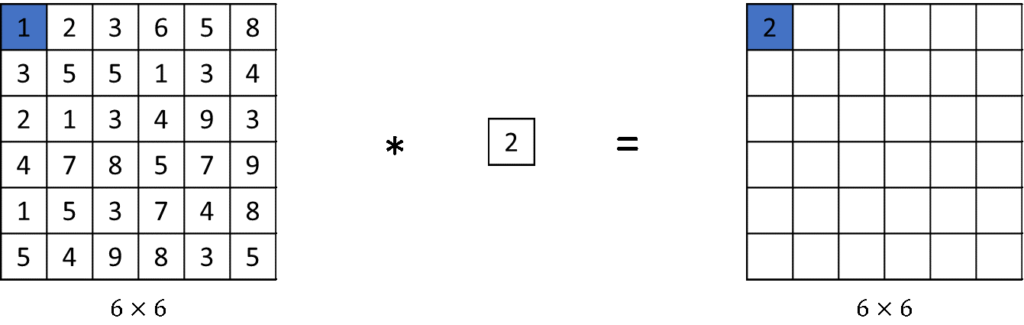  

- A convolution by a 1×1 filter doesn’t seem totally useful. We just multiply it by some number, but that’s the case of $6×6×1$ channel images.
  
- If we have a $6×6×32$, instead of $6×6×1$, then a convolution with a $1×1×32$ filter can do something that makes much more sense. Let’s look in the following picture.


  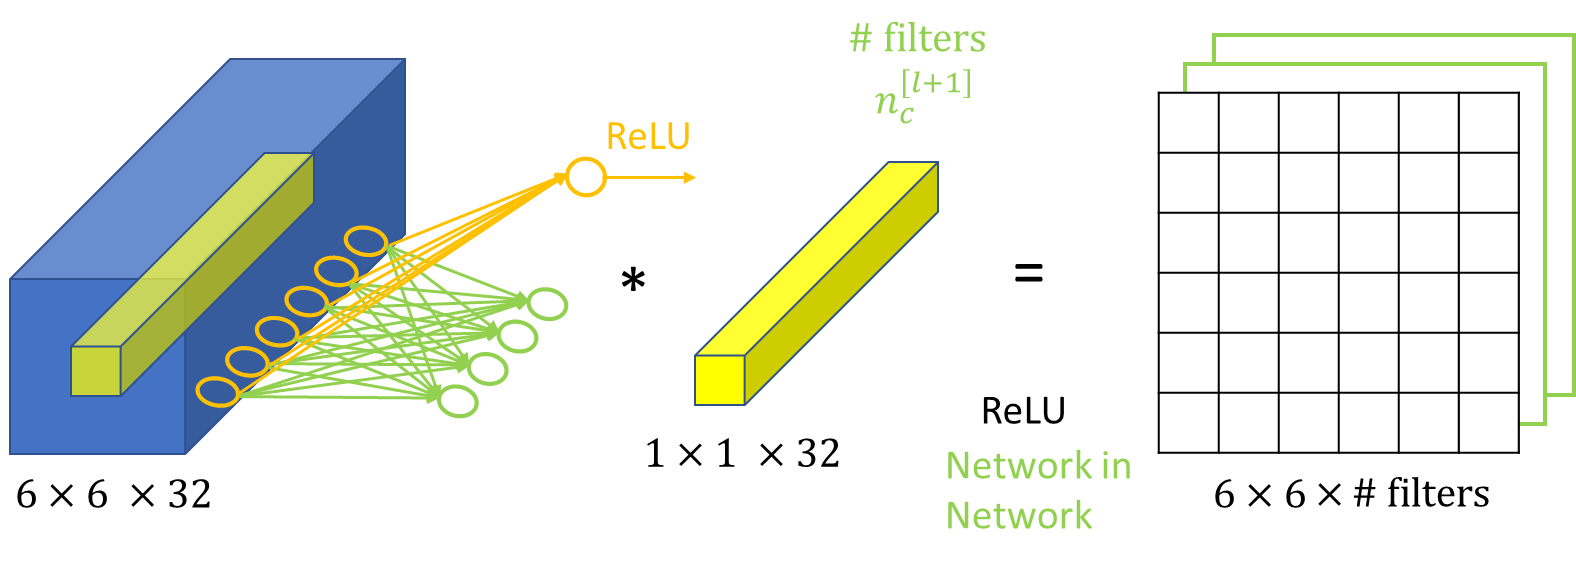

### Reduce Number of channels

- If we want to shrink the `height` and `width` we can use a `pooling layer`, and we know how to do that. But **what if the `number of channels` has gotten too big** and we want to shrink that?

- What we can do is use $32$ filters that are $1×1×192$.

  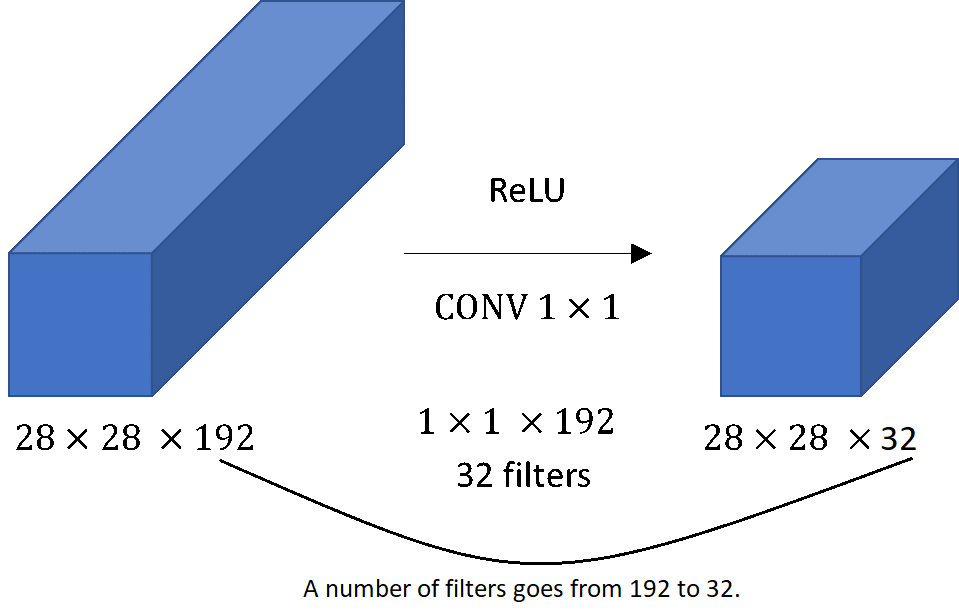

## Inception Network (GoogLeNet)

* [Reference](https://datahacker.rs/deep-learning-inception-network/)

- The `Inception Network` (also known as `GoogLeNet`) was developed by Google in $2014$ and introduced the concept of the "`Inception module`."

    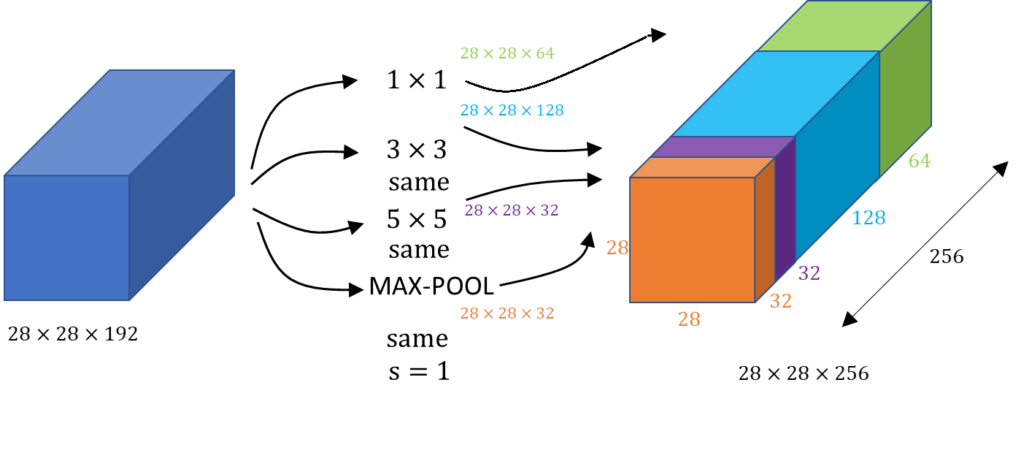

### The problem of the computational cost

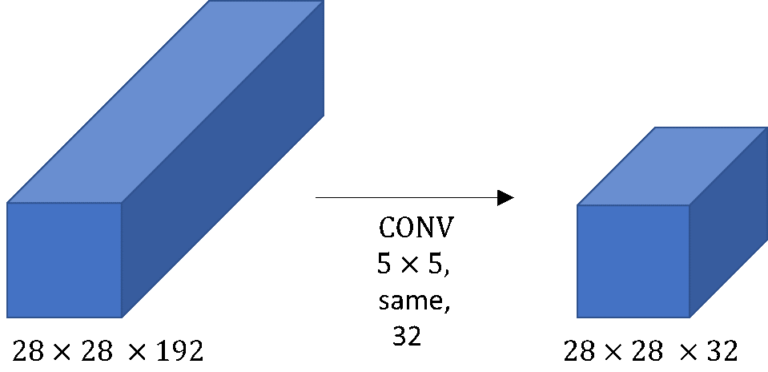

- Let’s look at a computational cost of generating a $28×28×32$. 
  
  - We have $32$ filters because we want the output to have $32$ channels. 
  
  - Each output value that we are going to use will be $5×5×192$. And if we multiply out all these numbers with $28×28×32$ outputs, this is equal to $120$ million.

- We’re going to use a `1×1 convolution` to reduce the volume to a $16$ channels instead of $192$ channels.

  -  Notice that the input and output dimensions are still the same. We input $28×28×192$ and output $28×28×32$ same as the previous example. 
  
    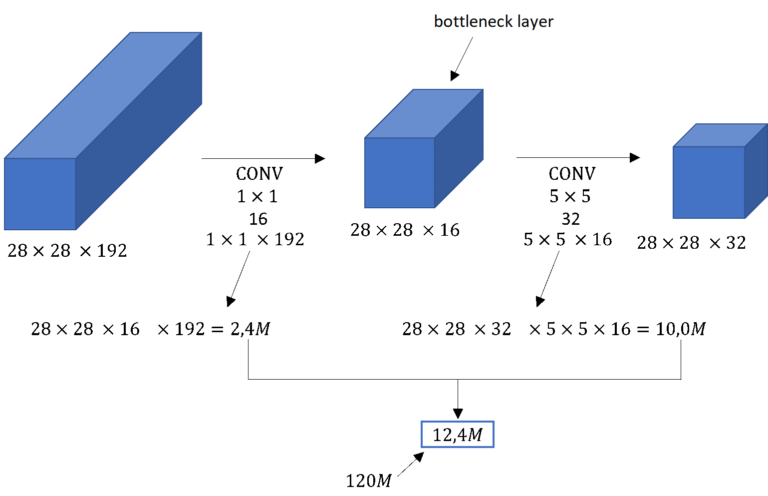
  

### Architecture

- **Input**: $224×224×3$ RGB images

- **Initial Layers**: Standard convolutions and `max pooling`

- **Middle**: $9$ `Inception modules`

- **End**: Global `average pooling` and `fully connected layer`

- **Output Layer**: $1000$ units (ImageNet classes)

- Also includes `auxiliary classifiers` during training to combat vanishing gradients

    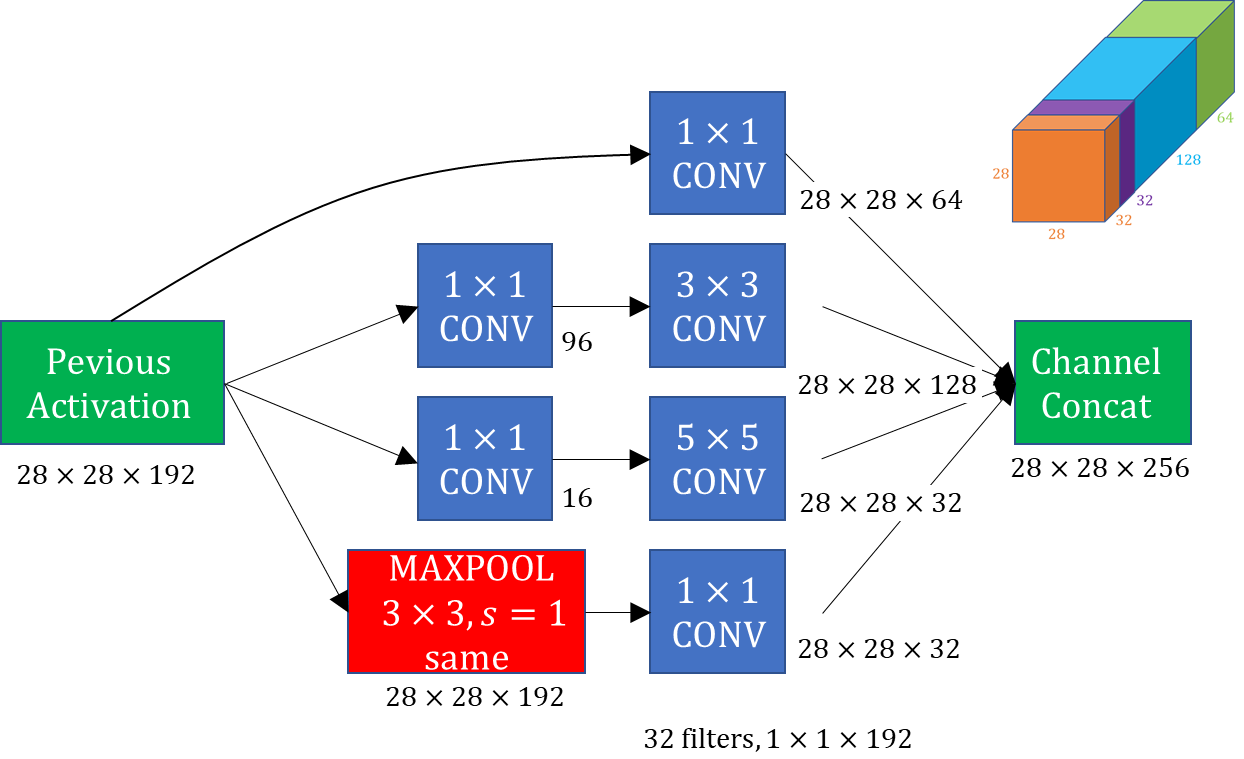


### Benefits

- Efficiently handles features at different scales

- Reduces parameters through $1×1$ `convolutions` (`bottleneck layers`)

- Achieved state-of-the-art performance with lower computational cost than previous models

    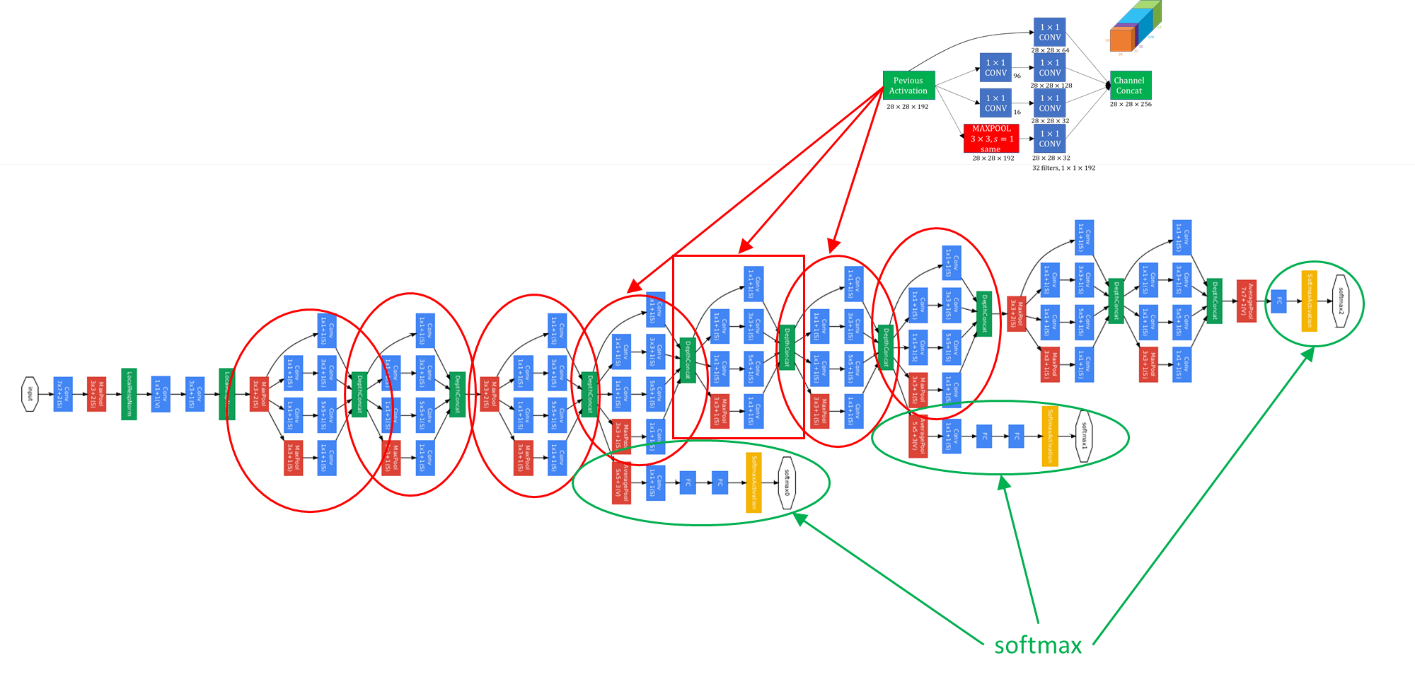

### Code Example

Demonstrating Inception module...


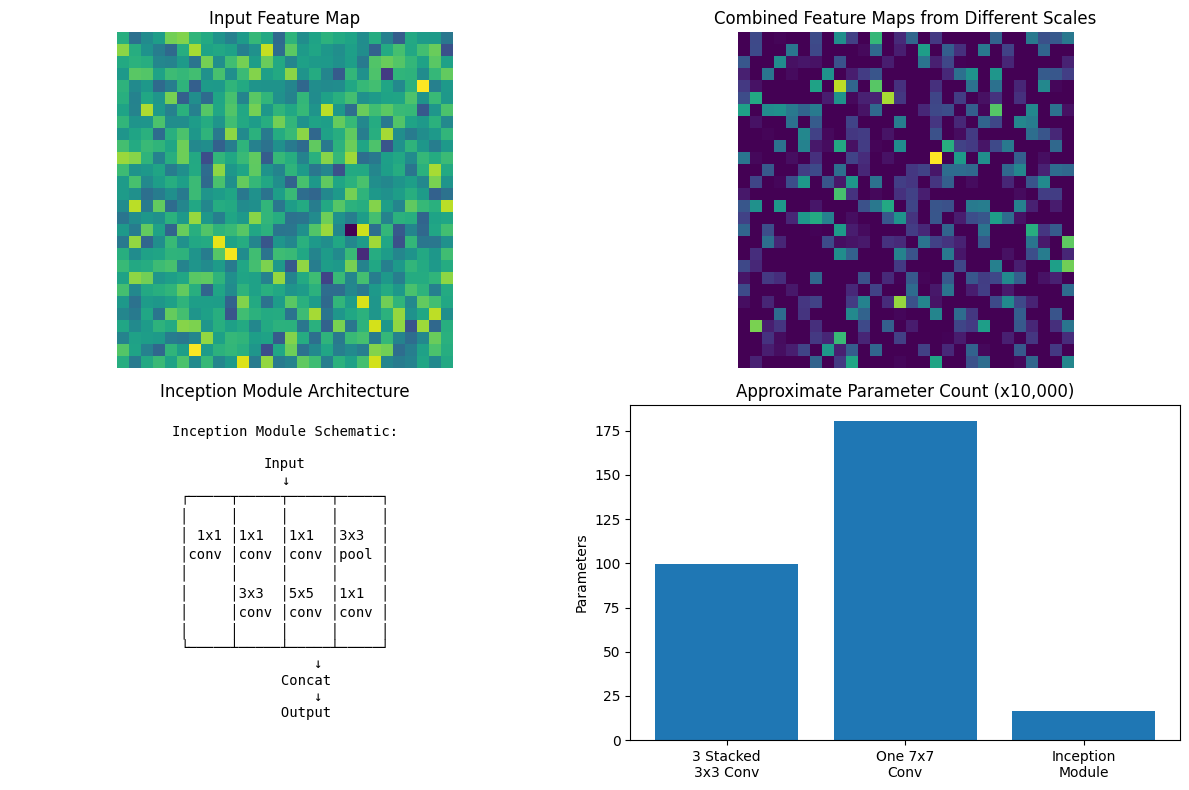

In [10]:
#==========================================================================
# 5. Inception Architecture
#==========================================================================
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionModule, self).__init__()
        
        # 1x1 convolution branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        
        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )
        
        # 3x3 pool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        # Concatenate the outputs along the channel dimension
        outputs = torch.cat([branch1, branch2, branch3, branch4], 1)
        return outputs

class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.7)
    
    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.avgpool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = self.relu(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc1(x)
        # N x 1024
        x = self.relu(x)
        x = self.dropout(x)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits
        
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)
        
        # Inception modules
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)
        
        # Auxiliary classifiers
        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = F.relu(x, inplace=True)
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = F.relu(x, inplace=True)
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = F.relu(x, inplace=True)
        x = self.maxpool2(x)
        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        
        aux1 = None
        if self.training and self.aux_logits:
            aux1 = self.aux1(x)
        
        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        
        aux2 = None
        if self.training and self.aux_logits:
            aux2 = self.aux2(x)
        
        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7
        
        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x num_classes
        
        if self.training and self.aux_logits:
            return x, aux1, aux2
        return x

def demonstrate_inception_module():
    # Create a visualization of the Inception module concept
    # Inception modules process input at multiple scales simultaneously
    
    # Create a sample input
    sample_input = torch.randn(1, 192, 28, 28)
    
    # Create an Inception module (replicating the 3a module from GoogLeNet)
    inception_module = InceptionModule(192, 64, 96, 128, 16, 32, 32)
    
    # Forward pass to get the output
    output = inception_module(sample_input)
    
    # Visualize the module architecture
    plt.figure(figsize=(12, 8))
    
    # Function to visualize feature maps
    def visualize_feature_maps(tensor, title, position):
        # Take the first channel for visualization
        feature_map = tensor[0, 0].detach().numpy()
        plt.subplot(2, 2, position)
        plt.imshow(feature_map, cmap='viridis')
        plt.title(title)
        plt.axis('off')
    
    # Visualize the input and outputs from each branch
    visualize_feature_maps(sample_input, "Input Feature Map", 1)
    
    # Process each branch separately to get intermediate outputs
    branch1_output = inception_module.branch1(sample_input)
    branch2_output = inception_module.branch2(sample_input)
    branch3_output = inception_module.branch3(sample_input)
    branch4_output = inception_module.branch4(sample_input)
    
    # Combine some for visualization
    combined = torch.cat([
        branch1_output[:, :1],  # Take the first channel from 1x1 branch
        branch2_output[:, :1],  # Take the first channel from 3x3 branch
        branch3_output[:, :1],  # Take the first channel from 5x5 branch
        branch4_output[:, :1]   # Take the first channel from pool branch
    ], dim=1)
    
    visualize_feature_maps(combined, "Combined Feature Maps from Different Scales", 2)
    
    # Show a schematic of the Inception module
    plt.subplot(2, 2, 3)
    plt.text(0.5, 0.5, "Inception Module Schematic:\n\n" +
             "Input\n↓\n" +
             "┌─────┬─────┬─────┬─────┐\n" +
             "│     │     │     │     │\n" +
             "│ 1x1 │1x1  │1x1  │3x3  │\n" +
             "│conv │conv │conv │pool │\n" +
             "│     │     │     │     │\n" +
             "│     │3x3  │5x5  │1x1  │\n" +
             "│     │conv │conv │conv │\n" +
             "│     │     │     │     │\n" +
             "└─────┴─────┴─────┴─────┘\n" +
             "        ↓\n" +
             "     Concat\n" +
             "        ↓\n" +
             "     Output",
             ha='center', va='center', fontfamily='monospace', fontsize=10)
    plt.axis('off')
    plt.title("Inception Module Architecture")
    
    # Show the computational efficiency
    plt.subplot(2, 2, 4)
    
    # Create simple bar chart comparing parameters
    labels = ['3 Stacked\n3x3 Conv', 'One 7x7\nConv', 'Inception\nModule']
    
    # Calculate approximate parameters (simplified for illustration)
    # Assuming input and output channels are both 192
    params_stacked_3x3 = 3 * (3 * 3 * 192 * 192)  # 3 layers of 3x3 convs
    params_7x7 = 7 * 7 * 192 * 192                # One 7x7 conv
    
    # For the Inception module (simplified calculation)
    params_inception = (
        (1 * 1 * 192 * 64) +                      # 1x1 branch
        (1 * 1 * 192 * 96 + 3 * 3 * 96 * 128) +   # 3x3 branch
        (1 * 1 * 192 * 16 + 5 * 5 * 16 * 32) +    # 5x5 branch
        (1 * 1 * 192 * 32)                        # Pool branch
    )
    
    params = [params_stacked_3x3, params_7x7, params_inception]
    
    # Normalize for better visualization
    params = [p / 10000 for p in params]
    
    plt.bar(labels, params)
    plt.title("Approximate Parameter Count (x10,000)")
    plt.ylabel("Parameters")
    
    plt.tight_layout()
    # plt.savefig('inception_module_visualization.png')
    plt.show()
    plt.close()

# Demonstrate the Inception module
print('Demonstrating Inception module...')
demonstrate_inception_module()

## Transfer Learning

- `Transfer learning` is a technique where a model trained on one task is repurposed for a related task, often with much less training data.

### How does the transfer learning work ?

- Let’s say we’re building a cat detector to recognize our own pet cat.  Let’s say our cats are called `Tigger` and `Misty`. We also have `Neither` as an output if detector doesn’t detect neither of these two cats.

    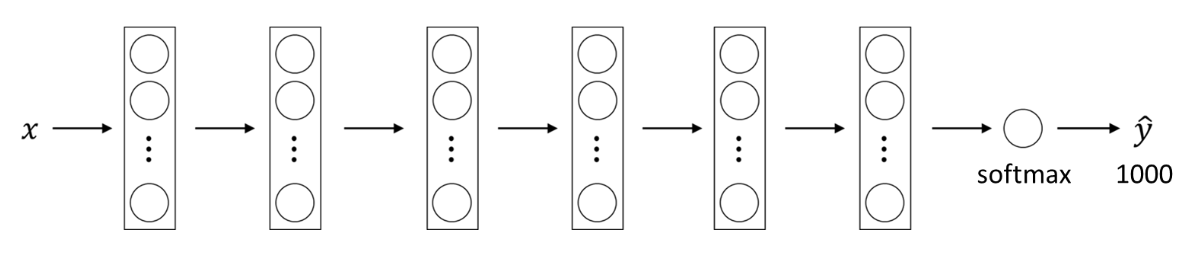

-  There are a lot of networks that have been trained on, for example the `Imagenet` dataset, which has $1000$ different classes. Hence, the network might have a `softmax` unit that outputs one of a thousand possible classes, as we can see in the picture above. 

   -  What we can do is get rid of the softmax layer and **create our own `softmax` unit** that outputs `Tigger` or `Misty` or `Neither`. 
      -  $parameter = 0$ says “don’t train those weights”.
      -  Setting a parameter $freeze=1$ does similar thing.
      -  In this case we will train only the softmax layer, but will freeze all of the earlier layers weights.

    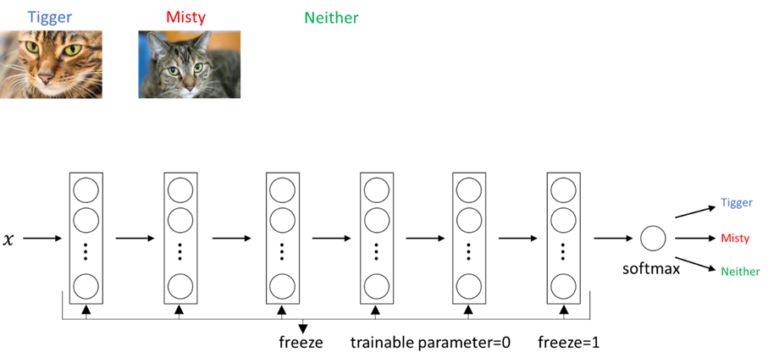

- If we have a **larger labeled dataset**, that is, if we have a lot of pictures of `Tigger`, `Misty` and a lot of pictures of `neither` of them, one thing we **could freeze fewer layers**. 
  - Maybe we can freeze just layers as presented in the picture below and then train these later layers.
  - One rule can be that if we have **more data**, **the number of layers we freeze could be smaller** and then **the number of layers we train on top could be greater**.

    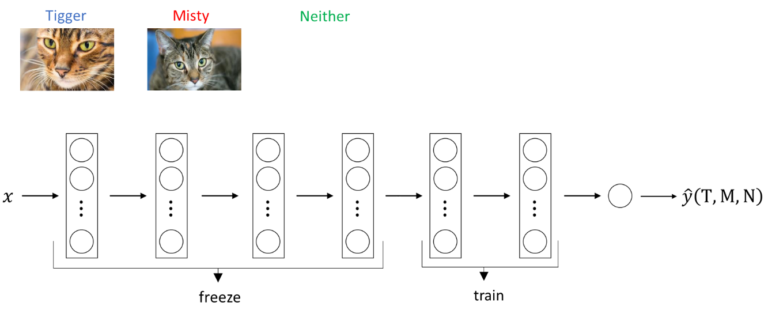

### Common Approaches

1. **Feature Extraction**:
   
   - Remove the final classification layer
   - Treat the rest of the network as a fixed feature extractor
   - Train a new classifier on these features

2. **Fine-Tuning**:
   - Remove the final classification layer
   - Replace with a new layer for your classes
   - Train the new layer while keeping **earlier layers fixed** (or train all layers with a small learning rate)

### When to Use Transfer Learning

- When you have **limited training data**
- When the new task is similar to the original task
- When you need to **train a model quickly**

### Code Example

Demonstrating transfer learning...


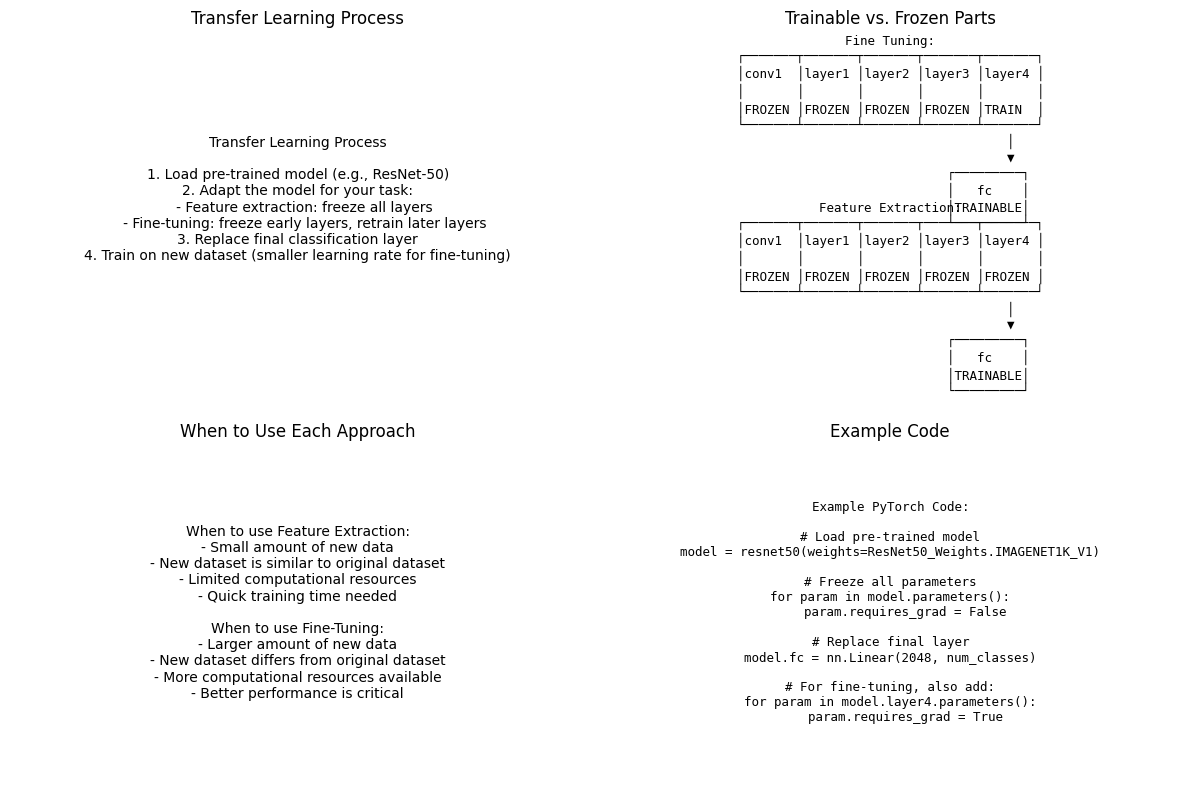

In [13]:
from torchvision.models import resnet50, ResNet50_Weights

#==========================================================================
# 6. Transfer Learning
#==========================================================================
def demonstrate_transfer_learning():
    # Demonstrate transfer learning process
    
    # Load pre-trained ResNet-50 using the new weights parameter instead of pretrained
    pretrained_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    
    # Example 1: Feature extraction (freeze all weights)
    model_feature_extraction = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    
    # Freeze all parameters
    for param in model_feature_extraction.parameters():
        param.requires_grad = False
    
    # Replace the final fully connected layer
    # ResNet50's FC layer has shape (2048, 1000)
    # Change it to predict for a new dataset with 10 classes
    model_feature_extraction.fc = nn.Linear(2048, 10)
    
    # Example 2: Fine-tuning (gradually unfreeze layers)
    model_fine_tuning = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    
    # First, freeze all parameters
    for param in model_fine_tuning.parameters():
        param.requires_grad = False
    
    # Replace the final fully connected layer
    model_fine_tuning.fc = nn.Linear(2048, 10)
    
    # Unfreeze the last convolutional block (layer4)
    for param in model_fine_tuning.layer4.parameters():
        param.requires_grad = True
    
    # Comparison of the two approaches
    plt.figure(figsize=(12, 8))
    
    # Visualize the transfer learning concept
    plt.subplot(2, 2, 1)
    plt.text(0.5, 0.5, 
             "Transfer Learning Process\n\n" +
             "1. Load pre-trained model (e.g., ResNet-50)\n" +
             "2. Adapt the model for your task:\n" +
             "   - Feature extraction: freeze all layers\n" +
             "   - Fine-tuning: freeze early layers, retrain later layers\n" +
             "3. Replace final classification layer\n" +
             "4. Train on new dataset (smaller learning rate for fine-tuning)",
             ha='center', va='center', fontsize=10)
    plt.axis('off')
    plt.title("Transfer Learning Process")
    
    # Visualize which parts of the network are trainable
    plt.subplot(2, 2, 2)
    
    # Show simplified ResNet architecture with trainable/frozen parts
    plt.text(0.5, 0.2, 
             "Feature Extraction:\n" +
             "┌───────┬───────┬───────┬───────┬───────┐\n" +
             "│conv1  │layer1 │layer2 │layer3 │layer4 │\n" +
             "│       │       │       │       │       │\n" +
             "│FROZEN │FROZEN │FROZEN │FROZEN │FROZEN │\n" +
             "└───────┴───────┴───────┴───────┴───────┘\n" +
             "                                │\n" +
             "                                ▼\n" +
             "                          ┌─────────┐\n" +
             "                          │   fc    │\n" +
             "                          │TRAINABLE│\n" +
             "                          └─────────┘",
             ha='center', va='center', fontfamily='monospace', fontsize=9)
    
    plt.text(0.5, 0.7, 
             "Fine Tuning:\n" +
             "┌───────┬───────┬───────┬───────┬───────┐\n" +
             "│conv1  │layer1 │layer2 │layer3 │layer4 │\n" +
             "│       │       │       │       │       │\n" +
             "│FROZEN │FROZEN │FROZEN │FROZEN │TRAIN  │\n" +
             "└───────┴───────┴───────┴───────┴───────┘\n" +
             "                                │\n" +
             "                                ▼\n" +
             "                          ┌─────────┐\n" +
             "                          │   fc    │\n" +
             "                          │TRAINABLE│\n" +
             "                          └─────────┘",
             ha='center', va='center', fontfamily='monospace', fontsize=9)
    plt.axis('off')
    plt.title("Trainable vs. Frozen Parts")
    
    # Show when to use each approach
    plt.subplot(2, 2, 3)
    plt.text(0.5, 0.5, 
             "When to use Feature Extraction:\n" +
             "- Small amount of new data\n" +
             "- New dataset is similar to original dataset\n" +
             "- Limited computational resources\n" +
             "- Quick training time needed\n\n" +
             "When to use Fine-Tuning:\n" +
             "- Larger amount of new data\n" +
             "- New dataset differs from original dataset\n" +
             "- More computational resources available\n" +
             "- Better performance is critical",
             ha='center', va='center', fontsize=10)
    plt.axis('off')
    plt.title("When to Use Each Approach")
    
    # Show example code
    plt.subplot(2, 2, 4)
    plt.text(0.5, 0.5, 
             "Example PyTorch Code:\n\n" +
             "# Load pre-trained model\n" +
             "model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)\n\n" +
             "# Freeze all parameters\n" +
             "for param in model.parameters():\n" +
             "    param.requires_grad = False\n\n" +
             "# Replace final layer\n" +
             "model.fc = nn.Linear(2048, num_classes)\n\n" +
             "# For fine-tuning, also add:\n" +
             "for param in model.layer4.parameters():\n" +
             "    param.requires_grad = True",
             ha='center', va='center', fontfamily='monospace', fontsize=9)
    plt.axis('off')
    plt.title("Example Code")
    
    plt.tight_layout()
    # plt.savefig('transfer_learning.png')
    plt.show()
    plt.close()
    
# Demonstrate transfer learning
print('Demonstrating transfer learning...')
demonstrate_transfer_learning()

## Data Augmentation

- `Data augmentation` is a technique to artificially **increase the size of the training dataset** by applying various transformations to the original images.

- [Reference](https://datahacker.rs/deep-learning-data-augmentation/)

### Common Augmentation Techniques

1. **Geometric Transformations**:
   - Horizontal/vertical flipping
  
      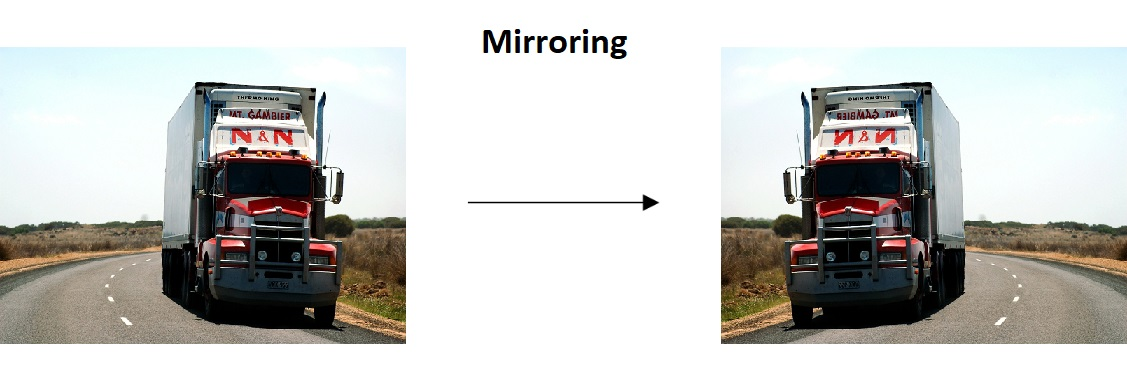

   - Random cropping
  
      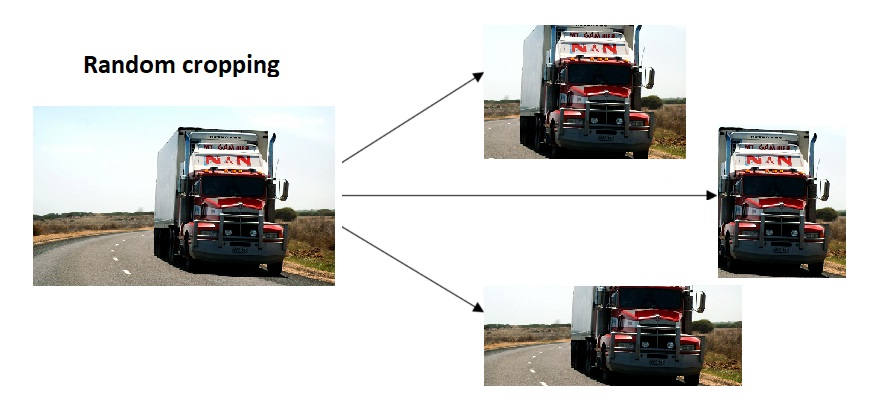

   - Rotation, scaling, shearing
   - Elastic deformations

2. **Color Transformations**:
   
   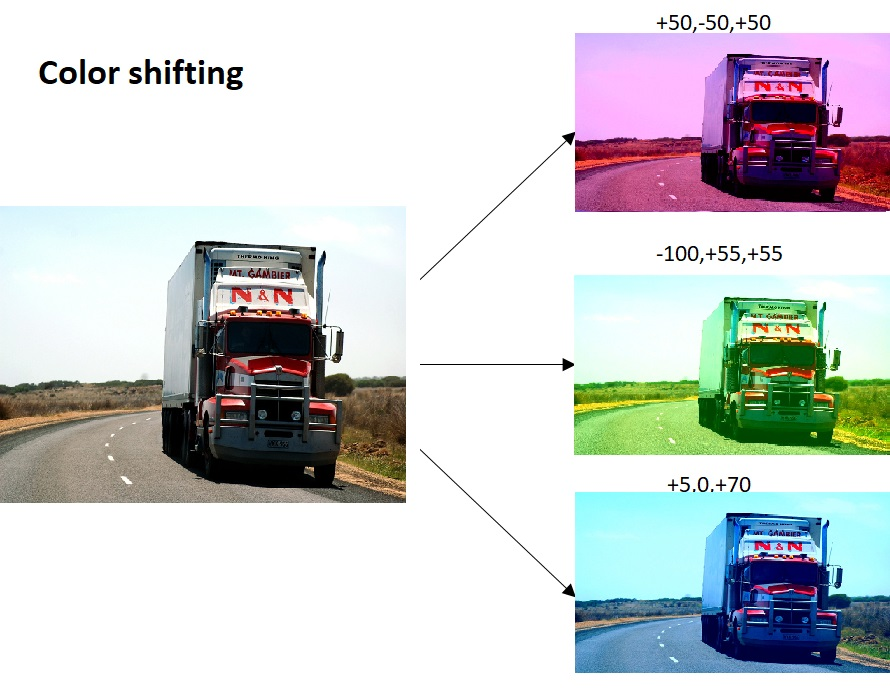

   - Changing brightness, contrast, saturation
   - Adding noise
   - PCA color augmentation (used in `AlexNet`)


3. **Mixing Images**:
   - Mixup: Combining images with weighted pixel-wise addition
   - CutMix: Replacing a portion of one image with a portion of another

### Code Example

Demonstrating data augmentation...


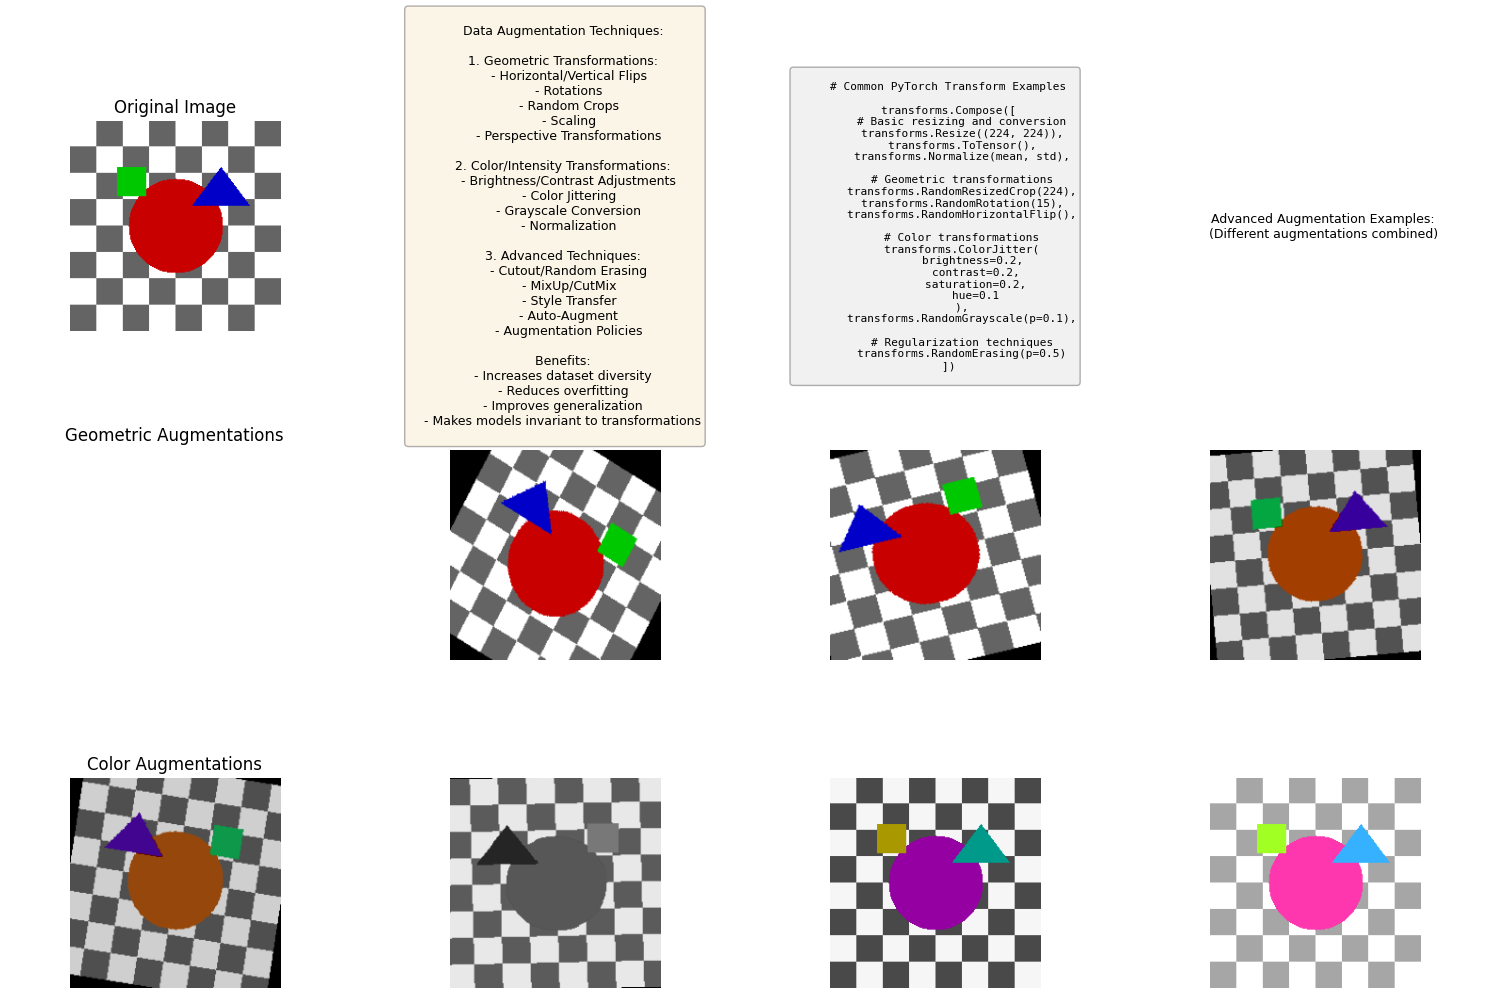

In [16]:
#==========================================================================
# 7. Data Augmentation
#==========================================================================
import cv2
def demonstrate_data_augmentation():
    # Create a custom dataset to demonstrate augmentation
    class SimpleDataset(Dataset):
        def __init__(self, transform=None):
            self.transform = transform
            
            # Create a sample image (checkerboard pattern)
            img = np.zeros((224, 224, 3), dtype=np.uint8)
            for i in range(0, 224, 28):
                for j in range(0, 224, 28):
                    if (i // 28 + j // 28) % 2 == 0:
                        img[i:i+28, j:j+28] = [255, 255, 255]
                    else:
                        img[i:i+28, j:j+28] = [100, 100, 100]
                        
            # Add some shapes for better visualization
            # Circle
            center = (112, 112)
            radius = 50
            cv_img = img.copy()
            cv2.circle(cv_img, center, radius, (200, 0, 0), -1)
            
            # Rectangle
            cv2.rectangle(cv_img, (50, 50), (80, 80), (0, 200, 0), -1)
            
            # Triangle
            points = np.array([[160, 50], [190, 90], [130, 90]], np.int32)
            cv2.fillPoly(cv_img, [points], (0, 0, 200))
            
            self.image = cv_img
            
        def __len__(self):
            return 1  # We only have one image for demonstration
            
        def __getitem__(self, idx):
            img = self.image
            img = Image.fromarray(img)
            
            if self.transform:
                img = self.transform(img)
                
            return img
            
    # Define augmentation transformations
    basic_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    geometric_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0),  # Always flip for demo
        transforms.RandomRotation(degrees=30),
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.ToTensor()
    ])
    
    color_transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        transforms.ToTensor()
    ])
    
    advanced_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(size=224, scale=(0.9, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor()
    ])
    
    # Create datasets with different transformations
    original_dataset = SimpleDataset(transform=basic_transform)
    geometric_dataset = SimpleDataset(transform=geometric_transform)
    color_dataset = SimpleDataset(transform=color_transform)
    advanced_dataset = SimpleDataset(transform=advanced_transform)
    
    # Initialize figure for visualization
    plt.figure(figsize=(15, 10))
    
    # Show original image
    img = original_dataset[0]
    img_np = img.permute(1, 2, 0).numpy()
    plt.subplot(3, 4, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')
    
    # Show multiple examples of each augmentation type
    
    # Geometric augmentations
    plt.subplot(3, 4, 5)
    plt.title("Geometric Augmentations")
    plt.axis('off')
    
    for i in range(3):
        img = geometric_dataset[0]  # Get a new transformed version
        img_np = img.permute(1, 2, 0).numpy()
        plt.subplot(3, 4, 6 + i)
        plt.imshow(img_np)
        plt.axis('off')
    
    # Color augmentations
    plt.subplot(3, 4, 9)
    plt.title("Color Augmentations")
    plt.axis('off')
    
    for i in range(3):
        img = color_dataset[0]  # Get a new transformed version
        img_np = img.permute(1, 2, 0).numpy()
        plt.subplot(3, 4, 10 + i)
        plt.imshow(img_np)
        plt.axis('off')
    
    # Create text description of augmentations
    description = """
    Data Augmentation Techniques:
    
    1. Geometric Transformations:
       - Horizontal/Vertical Flips
       - Rotations
       - Random Crops
       - Scaling
       - Perspective Transformations
    
    2. Color/Intensity Transformations:
       - Brightness/Contrast Adjustments
       - Color Jittering
       - Grayscale Conversion
       - Normalization
    
    3. Advanced Techniques:
       - Cutout/Random Erasing
       - MixUp/CutMix
       - Style Transfer
       - Auto-Augment
       - Augmentation Policies
    
    Benefits:
    - Increases dataset diversity
    - Reduces overfitting
    - Improves generalization
    - Makes models invariant to transformations
    """
    
    plt.subplot(3, 4, 2)
    plt.text(0.5, 0.5, description, 
             ha='center', va='center',
             fontsize=9, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    plt.axis('off')
    
    # Create a table showing common PyTorch transforms
    code_sample = """
    # Common PyTorch Transform Examples
    
    transforms.Compose([
        # Basic resizing and conversion
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        
        # Geometric transformations
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        
        # Color transformations
        transforms.ColorJitter(
            brightness=0.2, 
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        transforms.RandomGrayscale(p=0.1),
        
        # Regularization techniques
        transforms.RandomErasing(p=0.5)
    ])
    """
    
    plt.subplot(3, 4, 3)
    plt.text(0.5, 0.5, code_sample, 
             ha='center', va='center',
             fontsize=8,
             family='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
    plt.axis('off')
    
    # Show examples of advanced augmentations
    advanced_heading = """
    Advanced Augmentation Examples:
    (Different augmentations combined)
    """
    
    plt.subplot(3, 4, 4)
    plt.text(0.5, 0.5, advanced_heading, 
             ha='center', va='center',
             fontsize=9)
    plt.axis('off')
    
    for i in range(3):
        img = advanced_dataset[0]  # Get a new transformed version
        img_np = img.permute(1, 2, 0).numpy()
        plt.subplot(3, 4, 8 + i)
        plt.imshow(img_np)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
# Demonstrate data augmentation
print('Demonstrating data augmentation...')
demonstrate_data_augmentation()

## Summary
Week 2 of Andrew Ng's CNN course covers the evolution of CNN architectures that have shaped modern computer vision:

- **LeNet-5**: Pioneer CNN architecture for digit recognition
- **AlexNet**: Deeper network with ReLU, dropout, and GPU training
- **VGG-16**: Simple, uniform architecture with small filters
- **ResNet**: Revolutionary residual connections enabling very deep networks
- **Inception**: Parallel convolutions at different scales

### Key takeaways:

- CNNs have become progressively deeper over time
- Innovations like `skip connections` (`ResNet`)  address challenges in training deep networks
- `Transfer learning` allows leveraging pre-trained models for new tasks
- `Data augmentation` is crucial for generalization, especially with limited data

These architectures form the foundation for modern computer vision systems and continue to influence new CNN designs today.